In [78]:
import os
import sys

# os.path.join(os.path.dirname(__file__)
sys.path.append("../")  # location of config file
sys.path.append("../../../") 

import config
import glob
import numpy as np
from smartprint import smartprint as sprint
from preprocessing.ProcessRaw import ProcessRaw
from smartprint import smartprint as sprint

In [79]:
train_file_list = glob.glob("../../../train_data_all_cities/*")

import random
random.shuffle(train_file_list)

In [80]:
len(train_file_list)

3919361

In [96]:
import matplotlib.pyplot as plt
from scipy.spatial import minkowski_distance_p
from tqdm import tqdm

def compute_distances_of_x(file_list_filtered, prefix, folderpath, N=200):
    """
    file_list_filtered: as the name suggests
    prefix: filename prefix which was used to filter and create the file_list_filtered
    folderpath: as the name suggests
    """
    # each item in the list is named like this: ../../../train_data_all_cities/london-1-8-32-3414_y.npy 
    # implies we can get the temporal neighbours as x.split("_")[0].split("-")[-1] 
    #                                                        where x in file_list_filtered

    fileserial_num_list = [int(x.split(prefix)[1].split("_")[0]) for x in file_list_filtered]

    fileserial_num_list = (fileserial_num_list[:N])

    
    distances = []
    # print ("Nishant")
    
    data_cache = {}
    sequential_delete = []

    # print ("Nishant")
    for i in tqdm(range(len(fileserial_num_list))):
        serial_num = fileserial_num_list[i]
        
        query_point_fname = prefix + str(serial_num) + "_x.npy"
        
        if query_point_fname in data_cache:
            query_point_array = data_cache[query_point_fname]
        else:
            # sprint (os.getcwd())
            query_point_array = np.load(os.path.join(folderpath, query_point_fname))
            data_cache[query_point_fname] = np.array(query_point_array)
            sequential_delete.append(query_point_fname)
            
        for n in range(serial_num - config.cx_tnl, serial_num + config.cx_tnl):
            
            if n == serial_num: 
                # skip distance computation to self
                continue 
                
                
            filename_x = prefix + str(n) + "_x.npy"

            if filename_x in data_cache:
                neighbour_x_array = data_cache[filename_x]
            else:
                if os.path.exists(os.path.join(folderpath, filename_x)):
                    try:
                        neighbour_x_array = np.load(os.path.join(folderpath, filename_x))
                    except Exception as e:
                        print (filename_x)
                        print ("Error in single fie:")
                        os.system("ls -lrth " + folderpath + filename_x)
                        # raise Exception(e)
                        
                    data_cache[filename_x] = np.array(neighbour_x_array)
                    sequential_delete.append(filename_x)
                else:
                    # boundary cases
                    print ("Boundary case; skipping this query point")
                    break

            distances.append(np.max(np.abs(query_point_array - neighbour_x_array)))    
            if config.cx_viz_images:
                im = neighbour_x_array[:, :, 0].reshape((neighbour_x_array.shape[0], neighbour_x_array.shape[1], 1))
                plt.imshow(im)
                plt.colorbar()
                plt.show()
        
        # retain only some of the last values in the dict
        # sprint (len(data_cache))
        data_cache = {key: data_cache[key] for key in sequential_delete[-config.cx_tnl//2: ]}
        # print (neighbour_x_array.shape)
        
        # break
    # sprint (len(distances))
    # plt.hist(distances, bins=20, alpha=0.3, label=prefix + str(N))
    # plt.show()
    return distances
            
    
def compute_distances_of_x_random_neighbours(file_list_filtered, prefix, folderpath, N=200):
    """
    file_list_filtered: as the name suggests
    prefix: filename prefix which was used to filter and create the file_list_filtered
    folderpath: as the name suggests
    """
    # each item in the list is named like this: ../../../train_data_all_cities/london-1-8-32-3414_y.npy 
    # implies we can get the temporal neighbours as x.split("_")[0].split("-")[-1] 
    #                                                        where x in file_list_filtered

    fileserial_num_list = [int(x.split(prefix)[1].split("_")[0]) for x in file_list_filtered]

    fileserial_num_list = (fileserial_num_list[:N])

    
    distances = []
    # print ("Nishant")
    
    data_cache = {}
    sequential_delete = []

    # print ("Nishant")
    for i in tqdm(range(0, len(fileserial_num_list), 2)):
        serial_num = fileserial_num_list[i]
        
       
        query_point_fname = prefix + str(serial_num) + "_x.npy"
        
        serial_num = fileserial_num_list[i+1]
        candidate_radom_point_fname = prefix + str(serial_num) + "_x.npy"        
        
        if os.path.exists(os.path.join(folderpath, query_point_fname)):
            query_point_array = np.load(os.path.join(folderpath, query_point_fname))
        else:
            continue
        if os.path.exists(os.path.join(folderpath, candidate_radom_point_fname)):
            neighbour_x_array = np.load(os.path.join(folderpath, candidate_radom_point_fname))
        else:
            continue
        distances.append(np.max(np.abs(query_point_array - neighbour_x_array))) 
        # break
    # sprint (len(distances))
    # plt.hist(distances, bins=20, alpha=0.3, label=prefix + str(N))
    # plt.show()
    return distances
                

  0%|          | 0/5 [00:00<?, ?it/s]

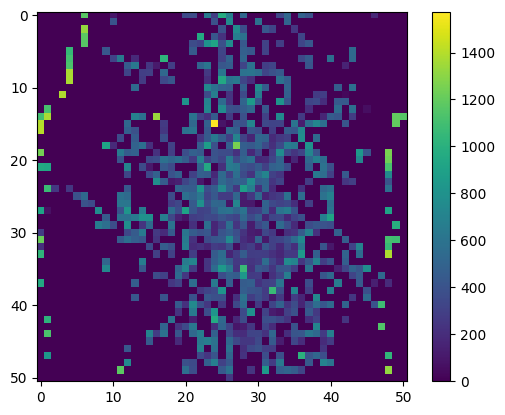

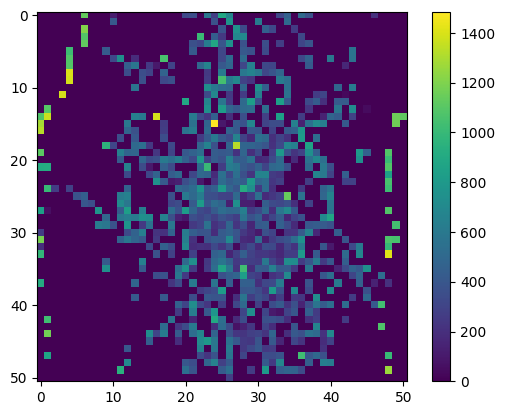

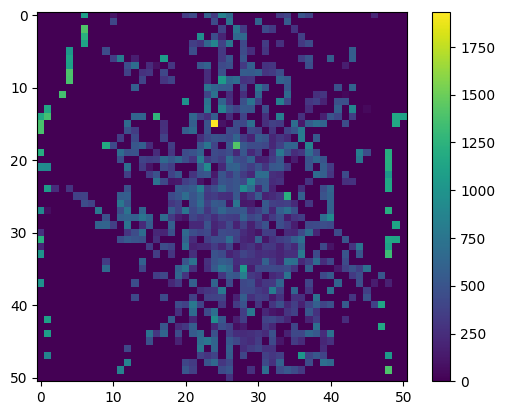

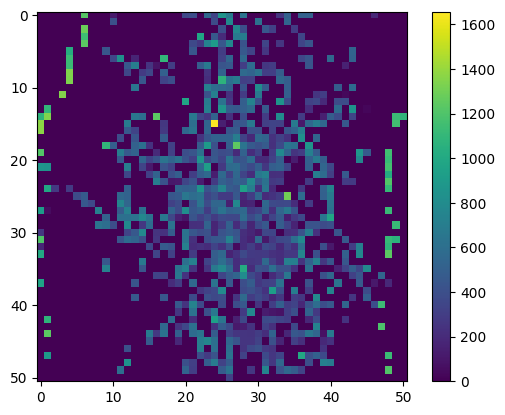

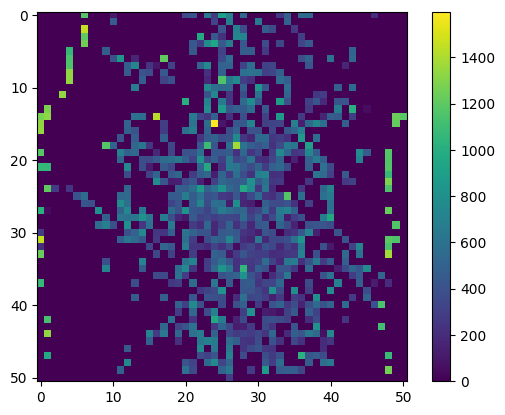

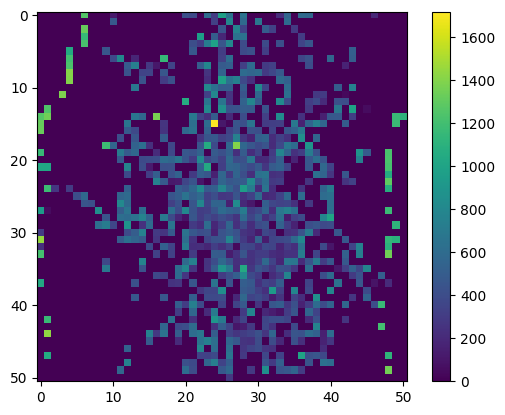

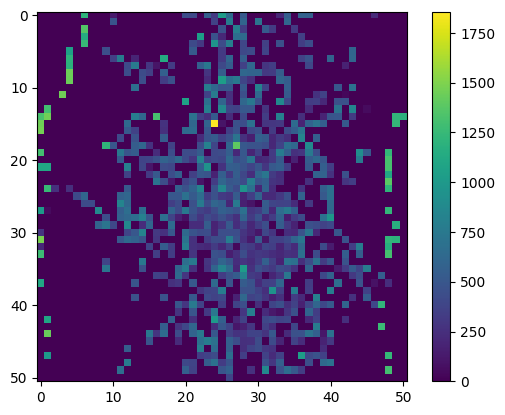

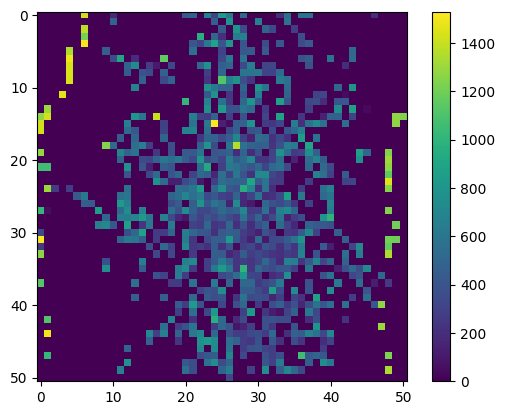

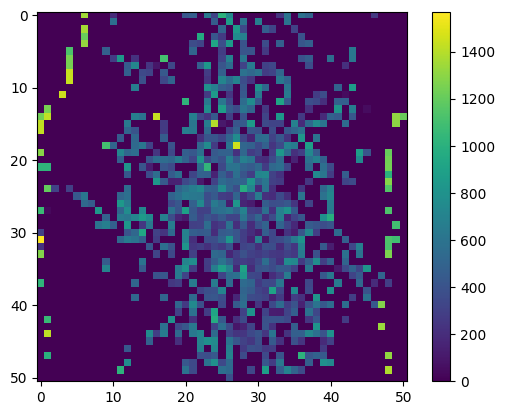

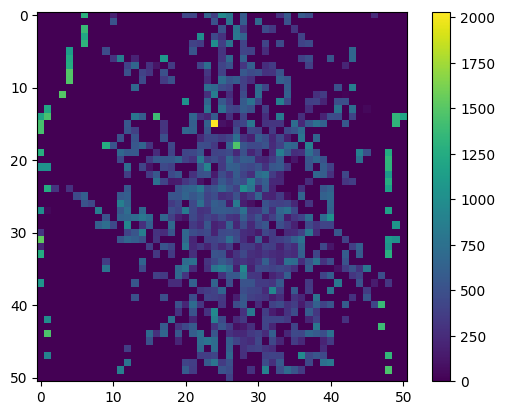

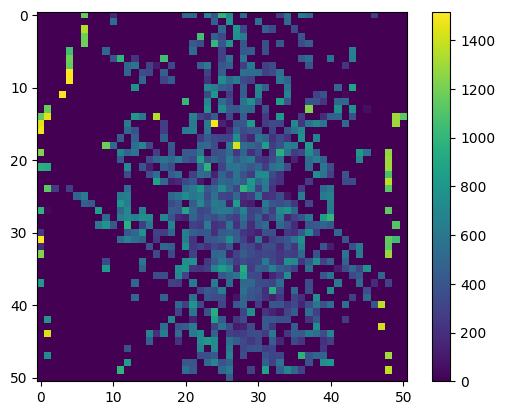

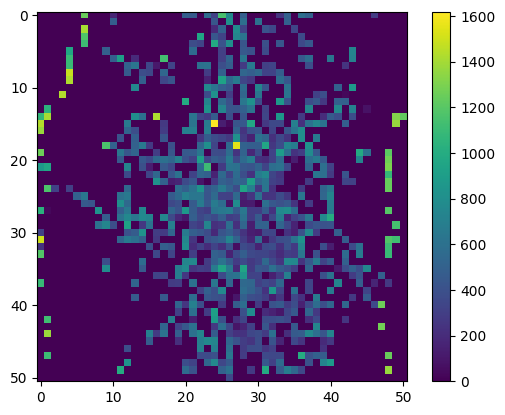

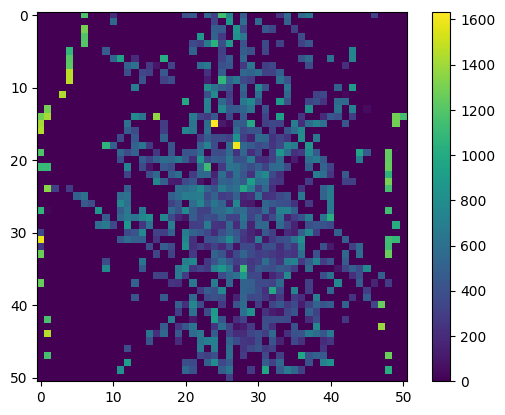

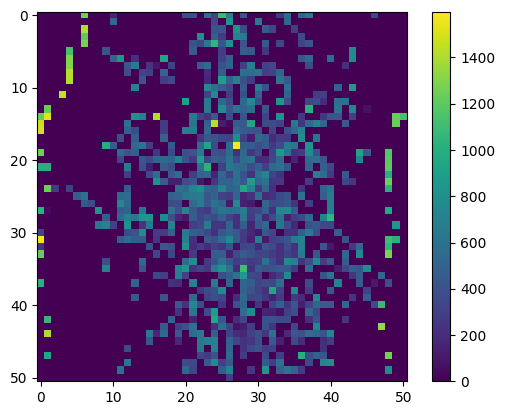

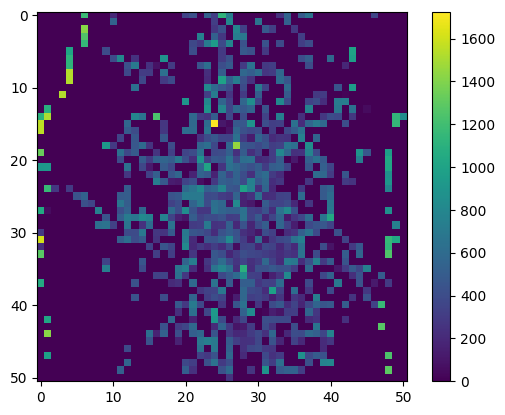

 20%|██        | 1/5 [00:02<00:08,  2.20s/it]

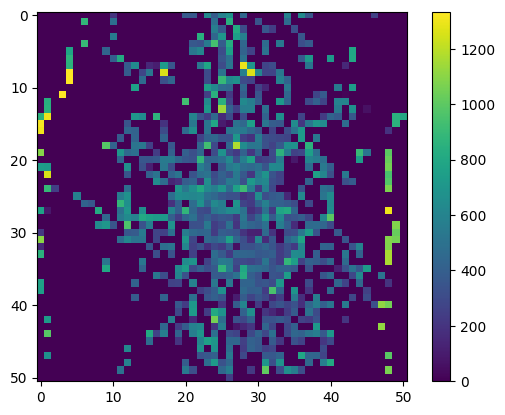

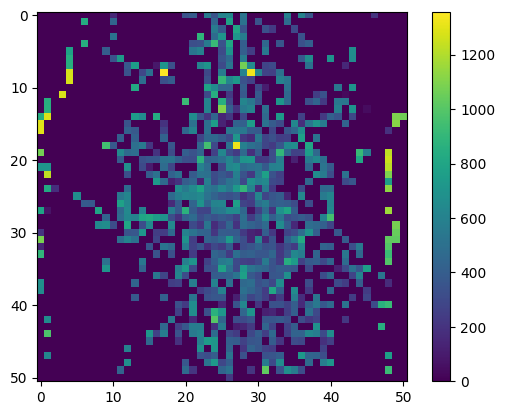

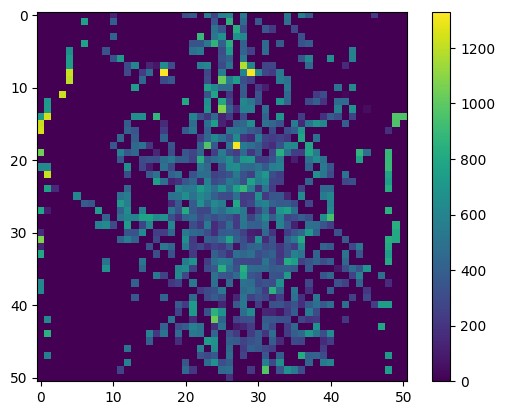

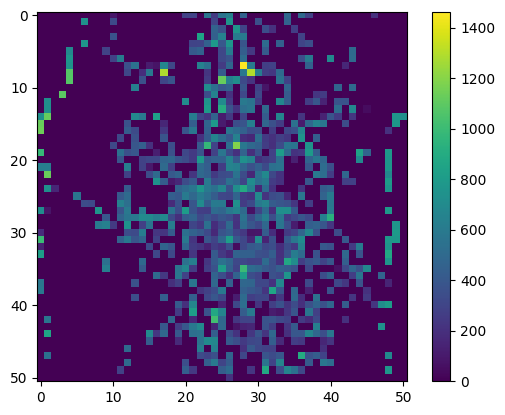

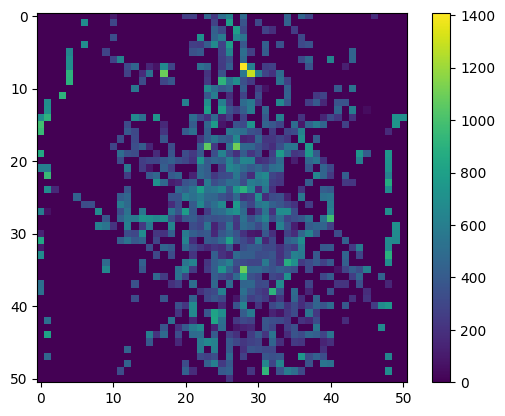

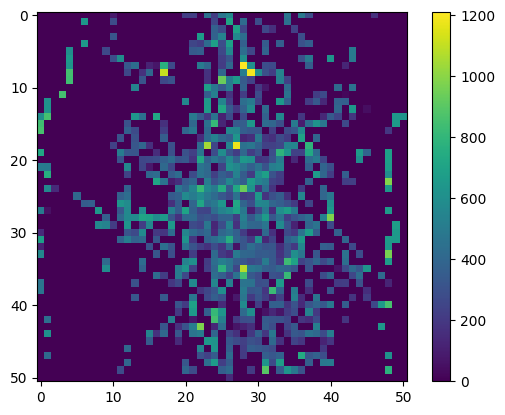

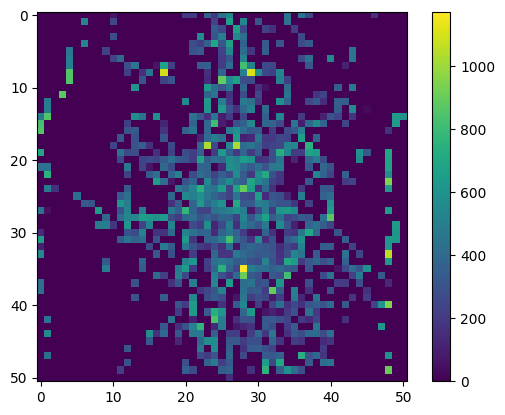

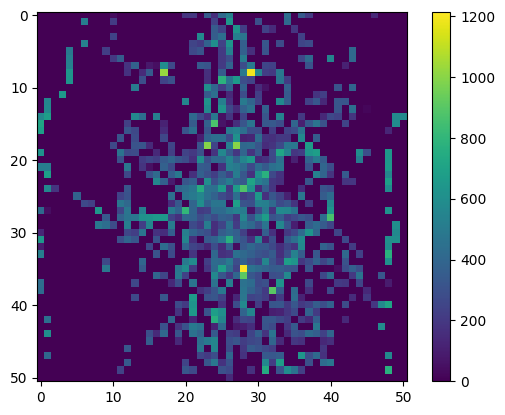

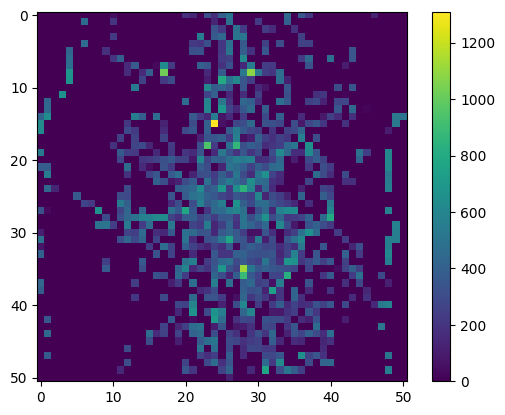

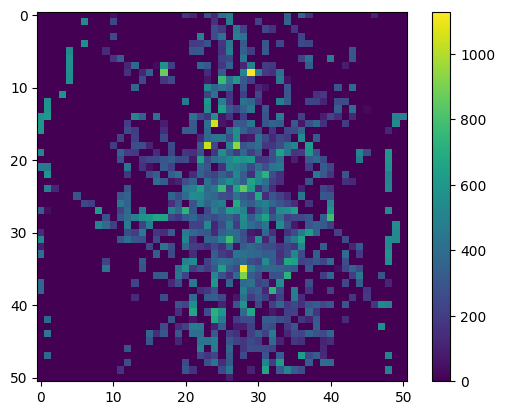

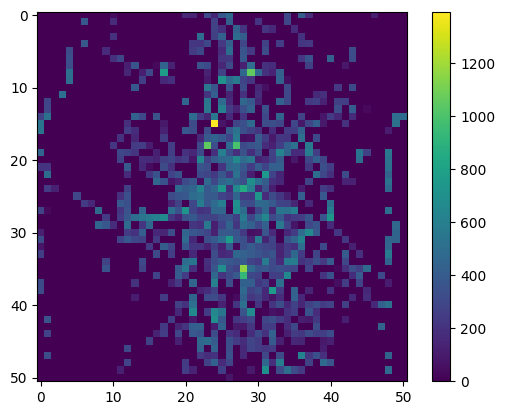

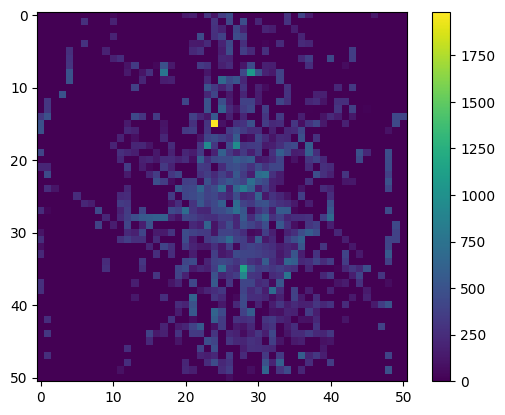

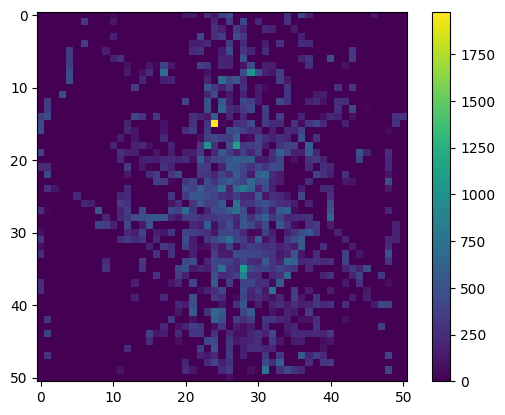

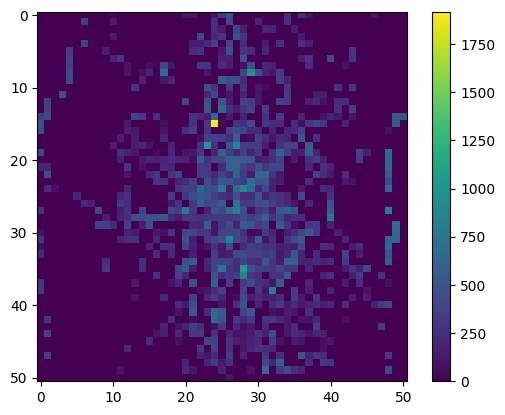

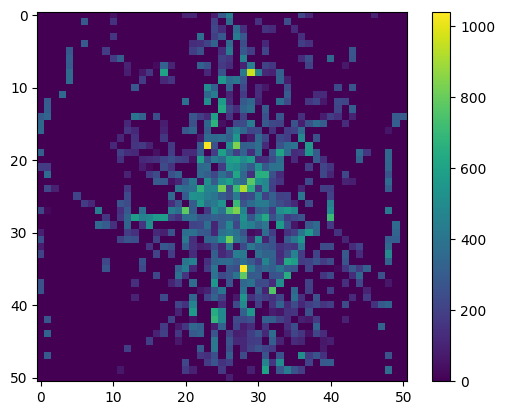

 40%|████      | 2/5 [00:04<00:07,  2.49s/it]

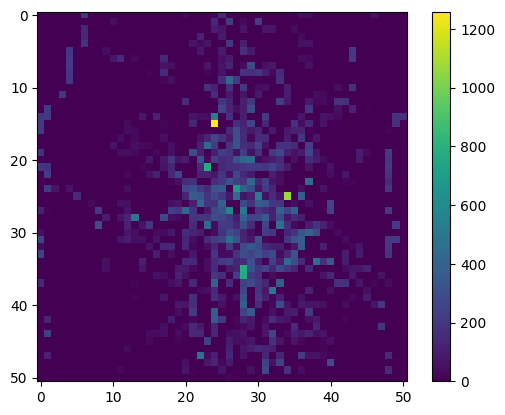

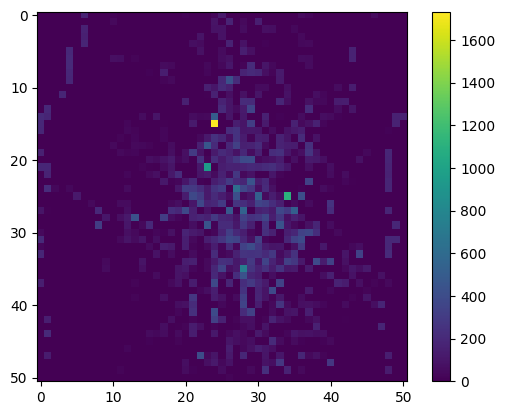

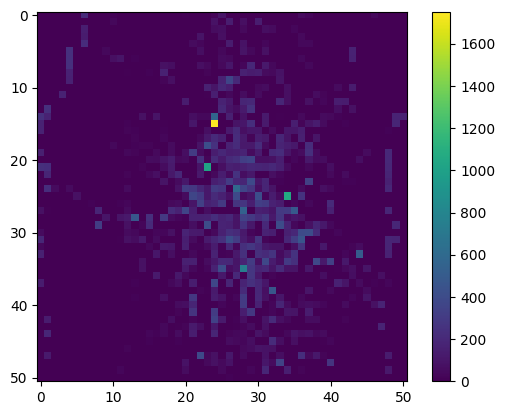

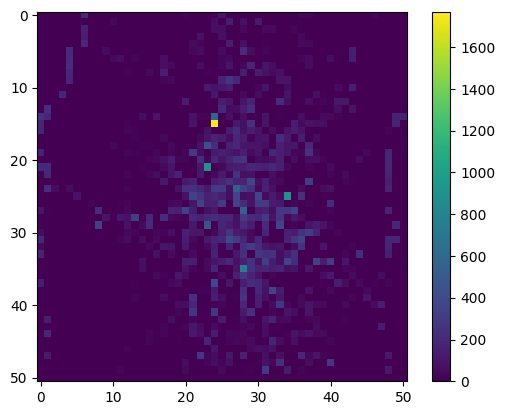

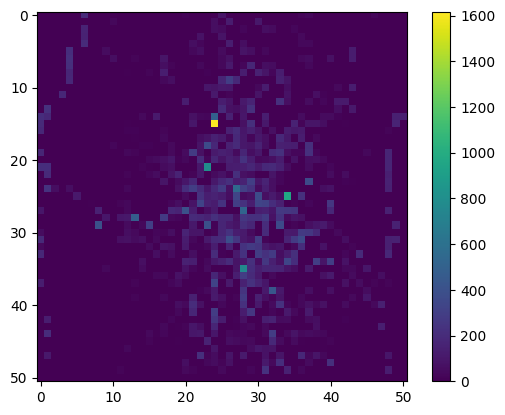

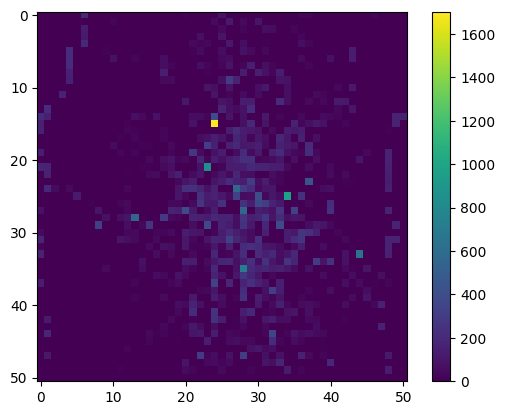

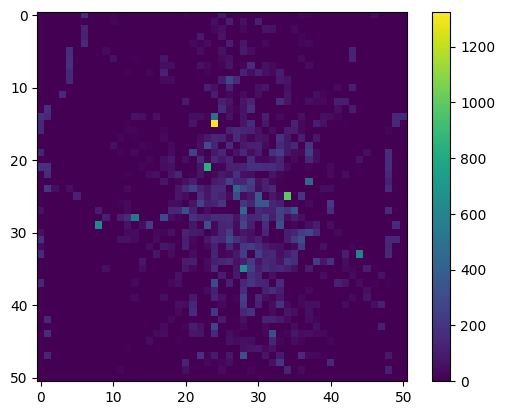

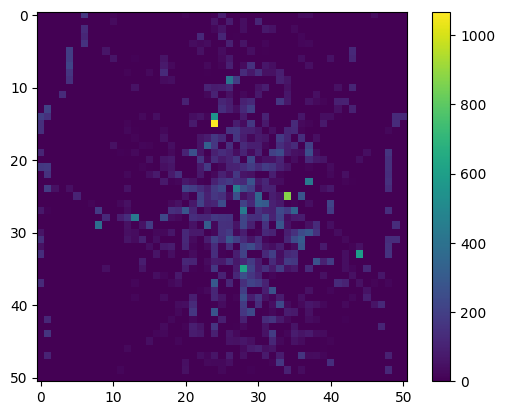

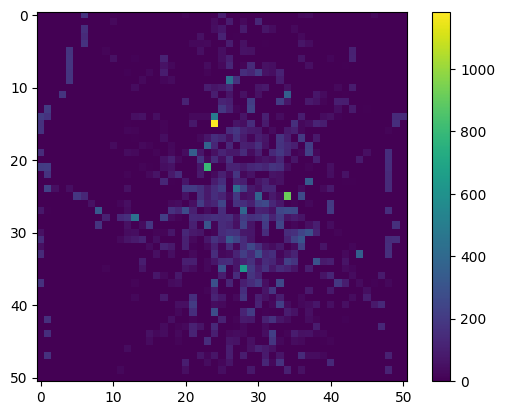

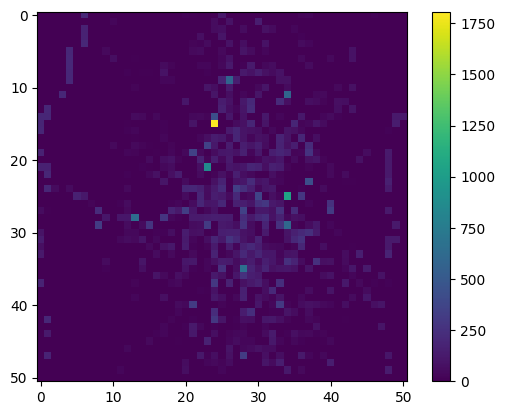

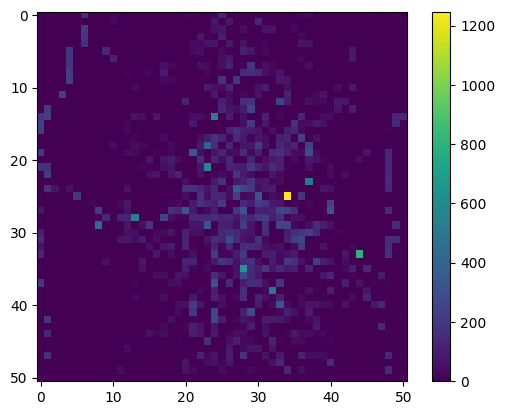

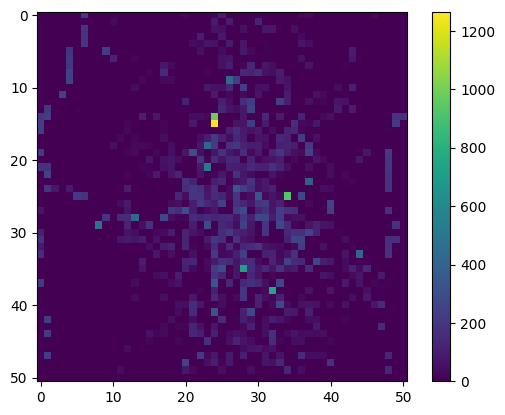

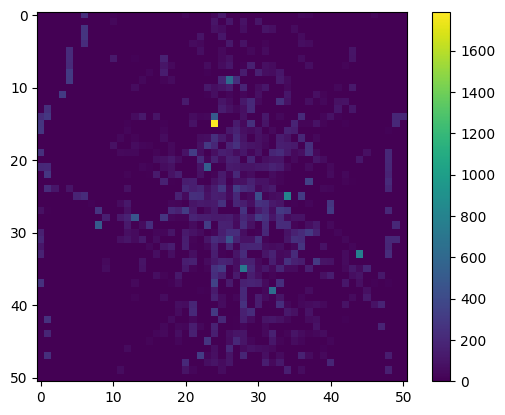

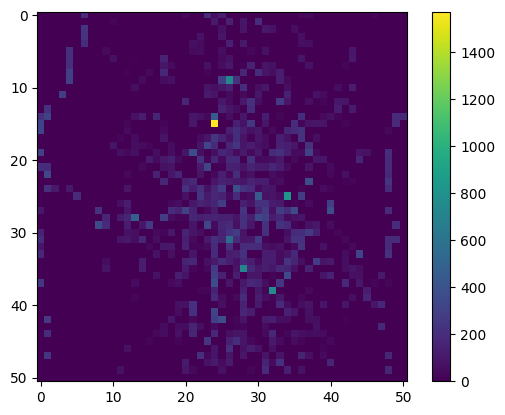

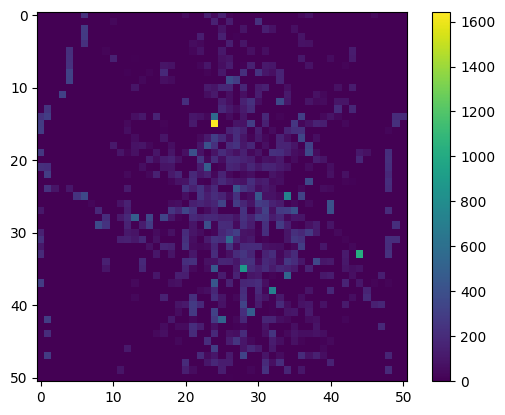

 60%|██████    | 3/5 [00:07<00:04,  2.35s/it]

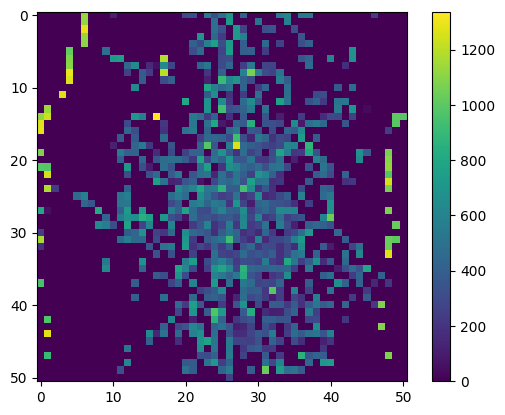

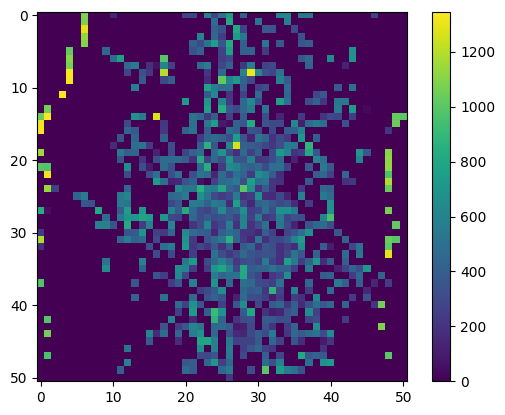

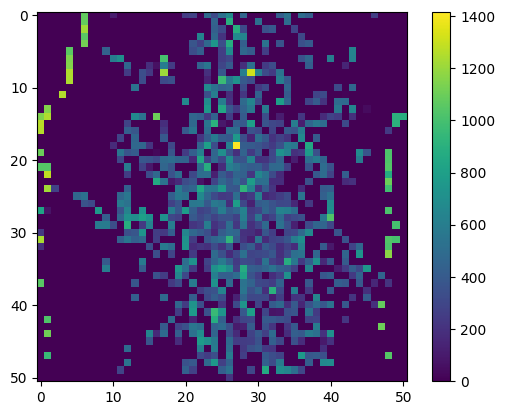

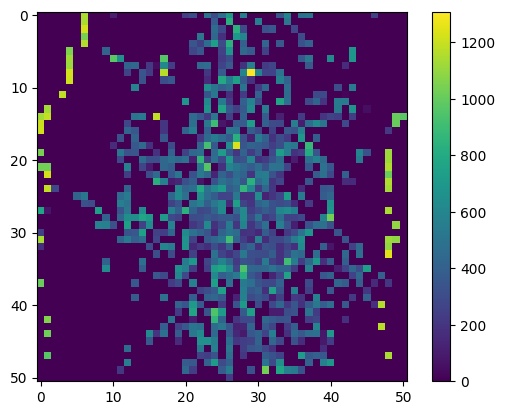

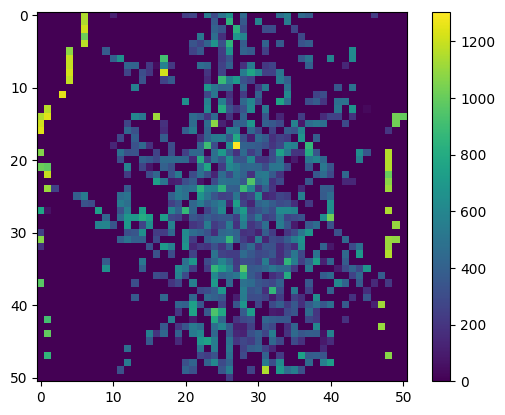

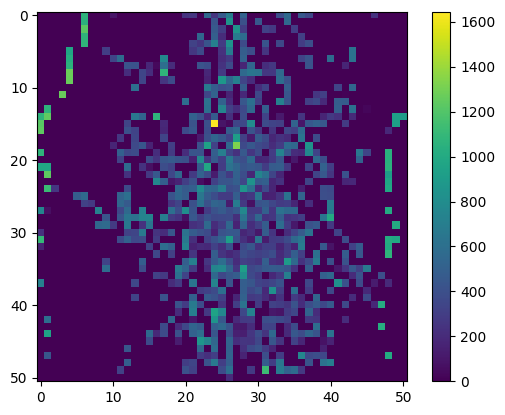

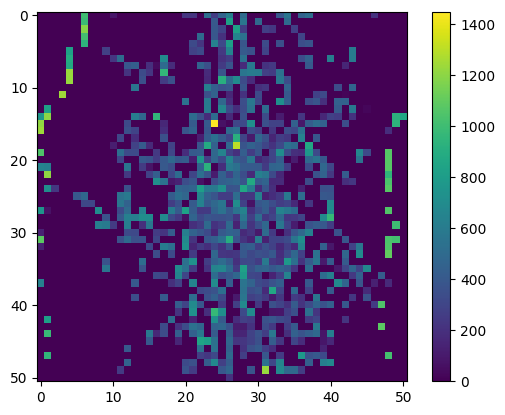

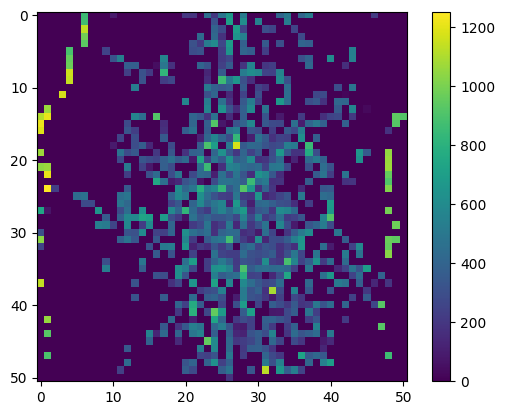

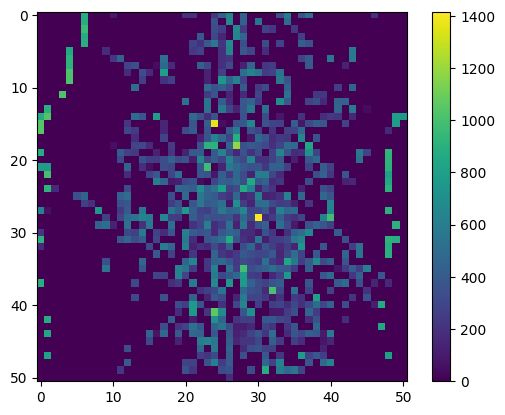

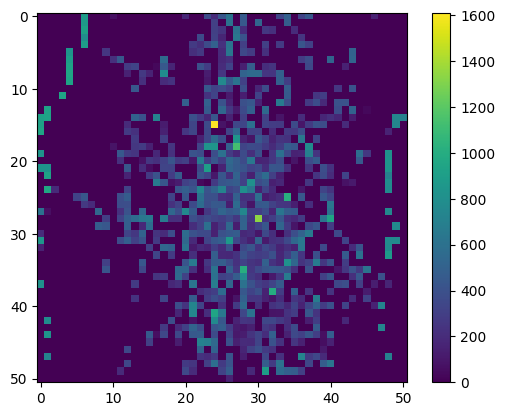

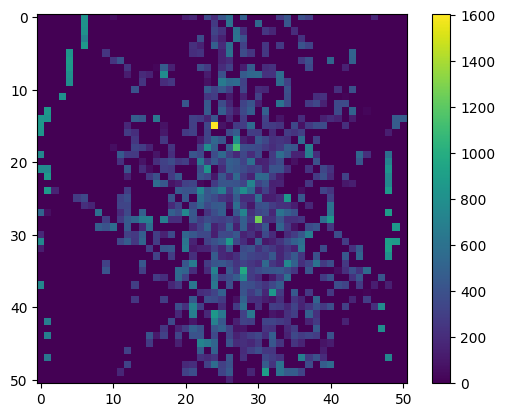

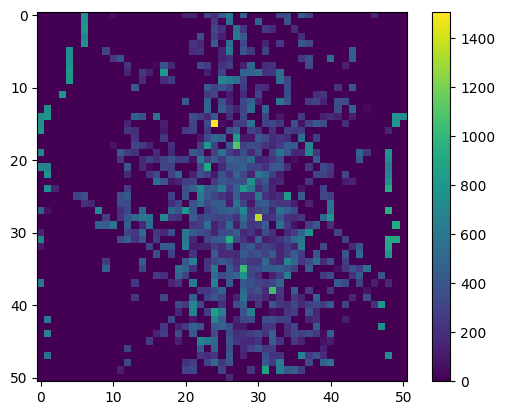

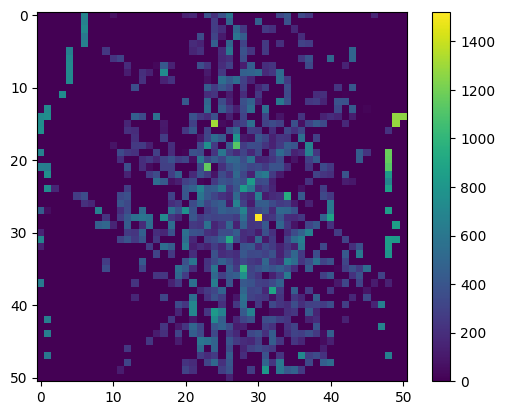

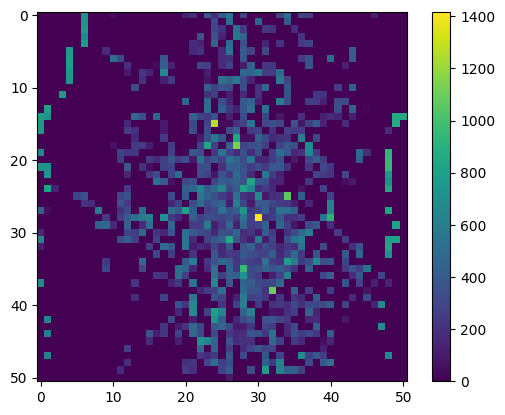

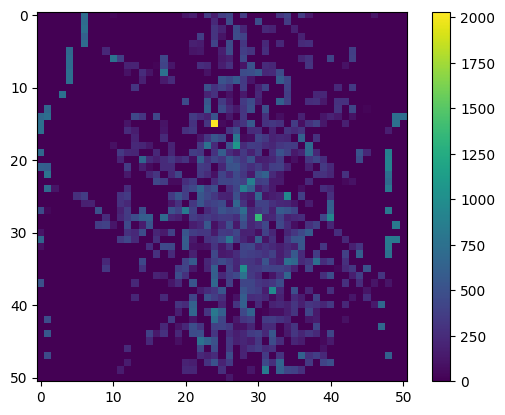

 80%|████████  | 4/5 [00:09<00:02,  2.29s/it]

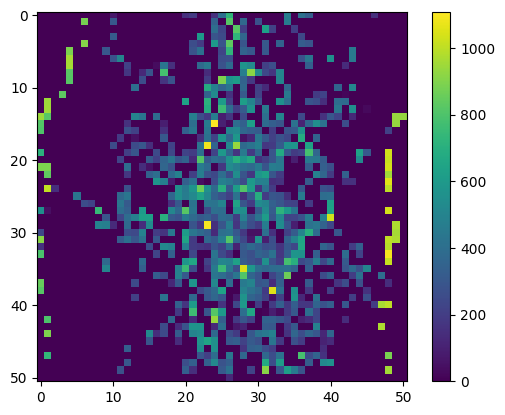

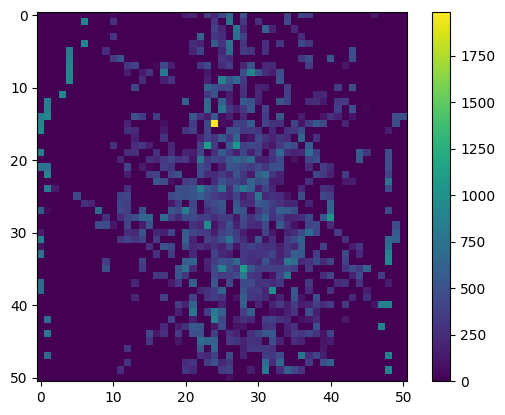

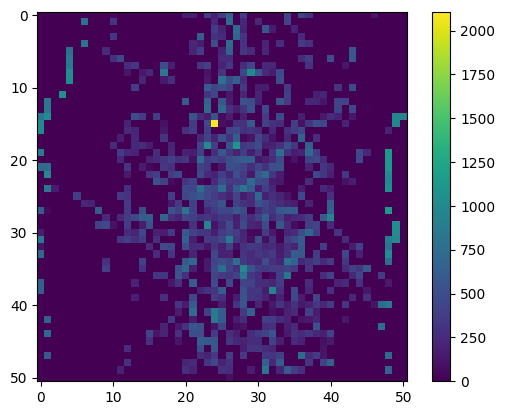

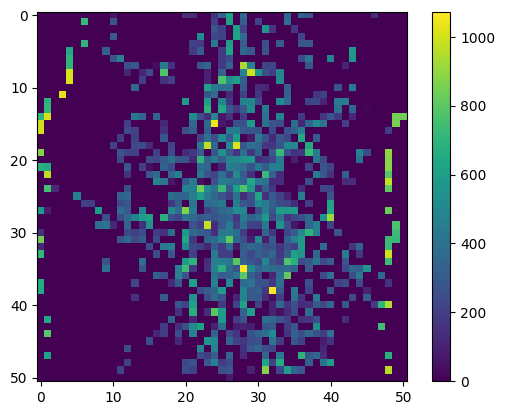

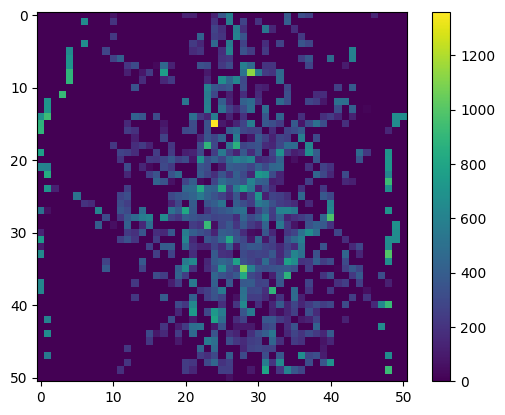

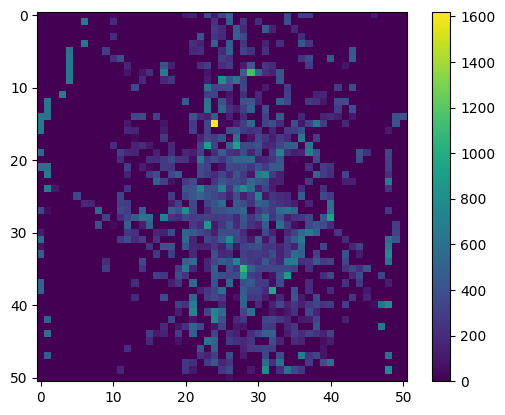

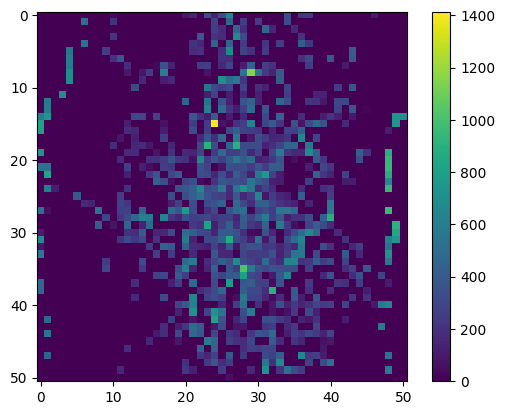

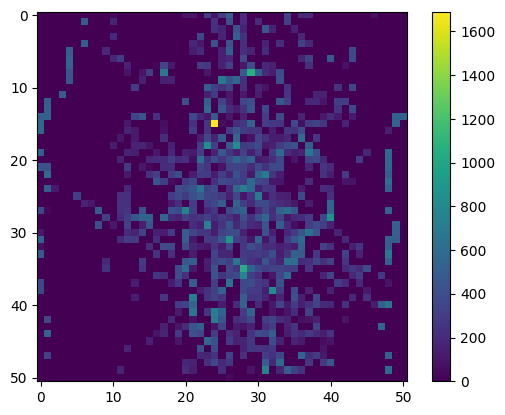

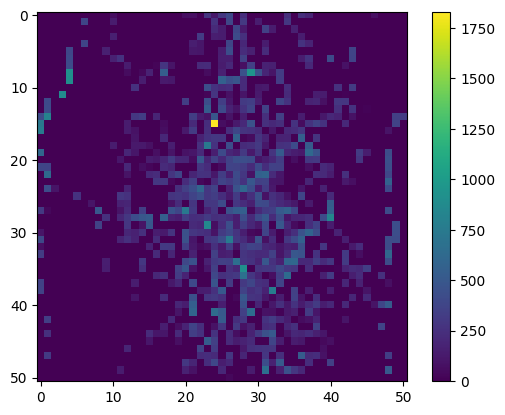

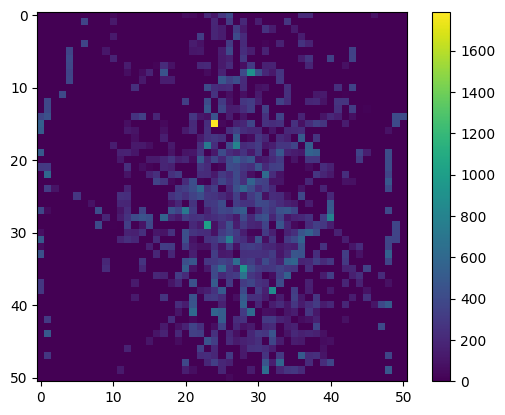

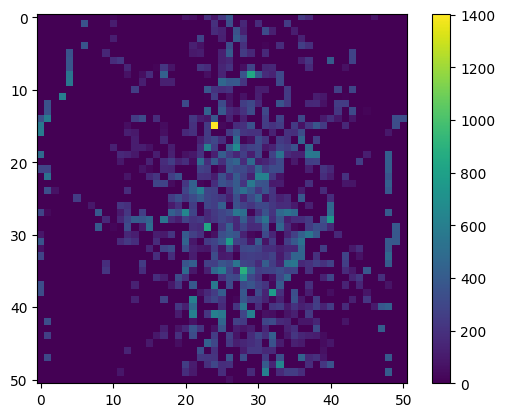

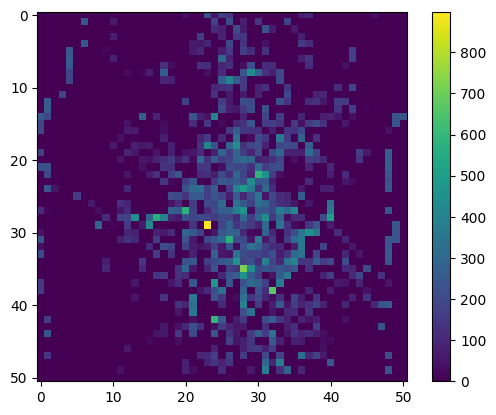

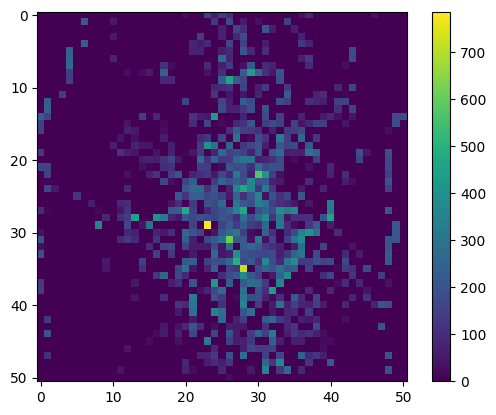

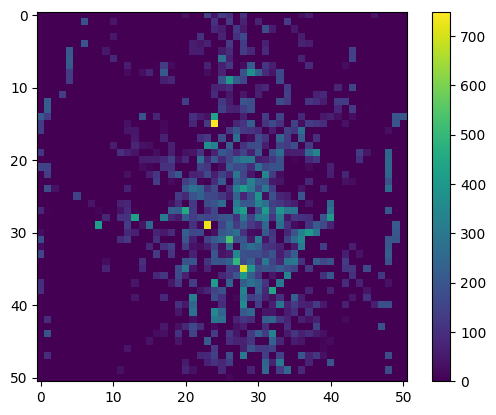

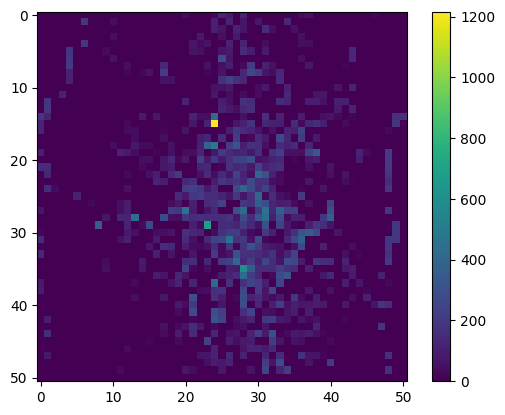

100%|██████████| 5/5 [00:11<00:00,  2.40s/it]


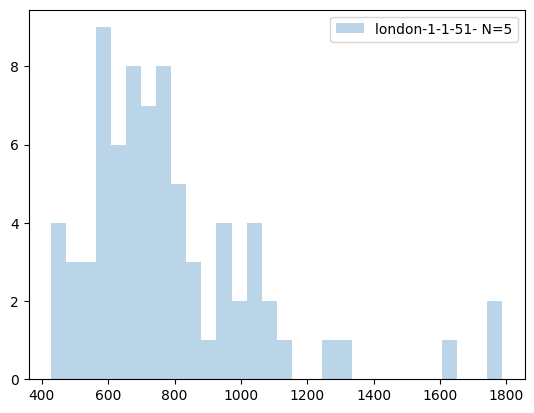

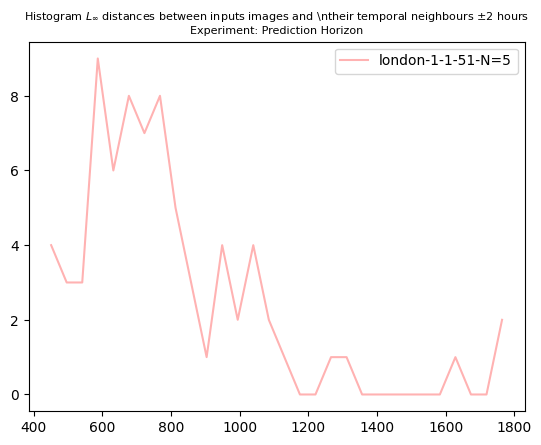

In [98]:
for city in config.city_list:

    # pred_horiz
    for N in [5]:
        hist_list = []
        colors = ["#FF0000", "#FF3300", "#FF6600", "#FF9900", "#FFCC00", "#FFFF00", "#CCE600", "#99CC00", "#66B200", "#339900"]
        for scale in [51]:
            for i_o_length in config.i_o_lengths_def:
                for index, pred_horiz in enumerate(config.pred_horiz_def):
                    prefix = ProcessRaw.file_prefix(city, i_o_length, pred_horiz, scale)
                    # sprint (prefix)
                    train_file_list_filtered = [x for x in train_file_list if (prefix in x and "_x.npy" in x)]
                    # sprint (len(train_file_list_filtered))
                    distances = compute_distances_of_x(train_file_list_filtered, prefix, "../../../train_data_all_cities/", N=N)

                    hist = plt.hist(distances, bins=30, alpha=0.3, label=prefix + " N=" + str(N))
                    bincentres = (hist[1][:-1] + hist[1][1:]) / 2

                    hist_list.append((hist[0], bincentres, prefix + "N=" +str(N), colors[index])) # hist[0] since plt.hist returns the bin counts, then the bin boundaries
                    # plt.plot()
        plt.legend()
        plt.show()


        for hist in hist_list:
            # hist[1]: x labels (the bin centres)
            # hist[0]: The actual bin counts
            # hist[3]: colors
            # hist[2]: label
            plt.plot(hist[1], hist[0], label=hist[2], color=hist[3], alpha=0.3,)
            plt.title(r"Histogram $L_{\infty}$ distances between inputs images and \ntheir temporal neighbours $\pm$2 hours " + "\nExperiment: Prediction Horizon", fontsize=8)
        plt.legend()
        plt.show()
    
    


100%|██████████| 100/100 [00:00<00:00, 2482.10it/s]


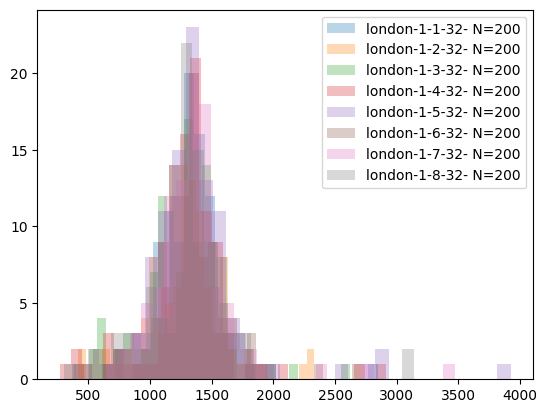

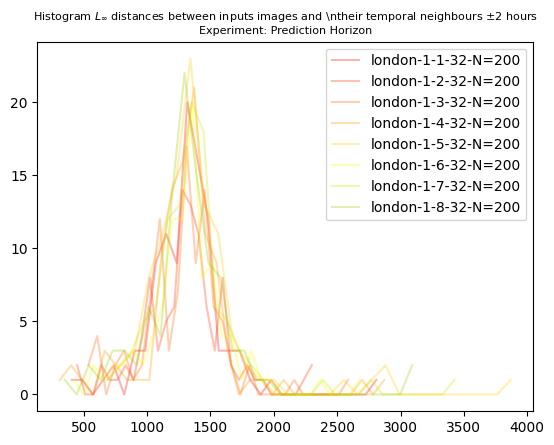

100%|██████████| 200/200 [00:00<00:00, 2582.50it/s]


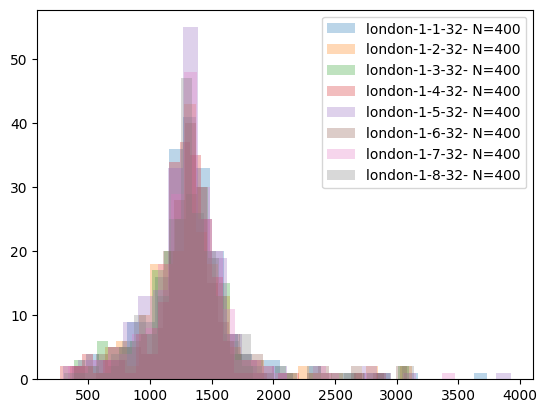

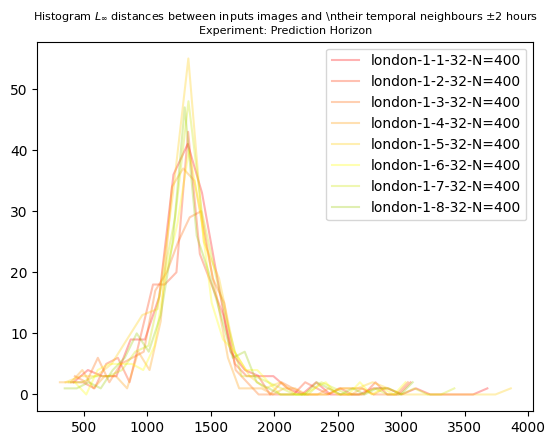

100%|██████████| 400/400 [00:00<00:00, 2517.96it/s]


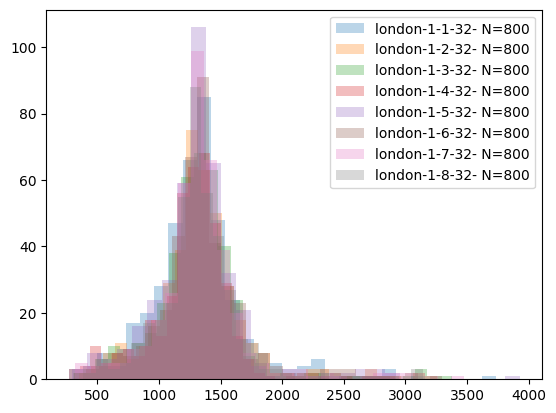

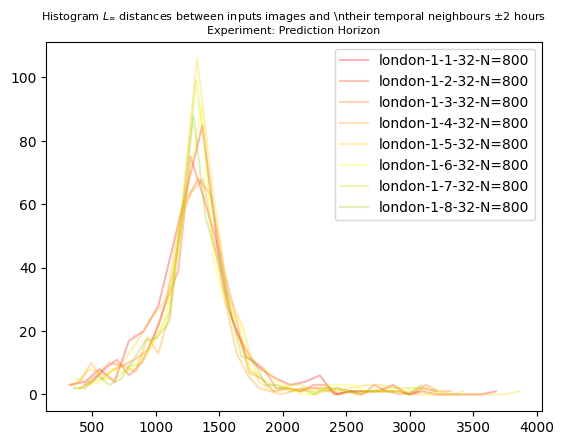

In [89]:
for city in config.city_list:

    # pred_horiz
    for N in [200, 400, 800]:
        hist_list = []
        colors = ["#FF0000", "#FF3300", "#FF6600", "#FF9900", "#FFCC00", "#FFFF00", "#CCE600", "#99CC00", "#66B200", "#339900"]
        for scale in config.scales_def:
            for i_o_length in config.i_o_lengths_def:
                for index, pred_horiz in enumerate(config.pred_horiz):
                    prefix = ProcessRaw.file_prefix(city, i_o_length, pred_horiz, scale)
                    # sprint (prefix)
                    train_file_list_filtered = [x for x in train_file_list if (prefix in x and "_x.npy" in x)]
                    # sprint (len(train_file_list_filtered))
                    distances = compute_distances_of_x_random_neighbours(train_file_list_filtered, prefix, "../../../train_data_all_cities/", N=N)

                    hist = plt.hist(distances, bins=30, alpha=0.3, label=prefix + " N=" + str(N))
                    bincentres = (hist[1][:-1] + hist[1][1:]) / 2

                    hist_list.append((hist[0], bincentres, prefix + "N=" +str(N), colors[index])) # hist[0] since plt.hist returns the bin counts, then the bin boundaries
                    # plt.plot()
        plt.legend()
        plt.show()


        for hist in hist_list:
            # hist[1]: x labels (the bin centres)
            # hist[0]: The actual bin counts
            # hist[3]: colors
            # hist[2]: label
            plt.plot(hist[1], hist[0], label=hist[2], color=hist[3], alpha=0.3,)
            plt.title(r"Histogram $L_{\infty}$ distances between inputs images and \ntheir temporal neighbours $\pm$2 hours " + "\nExperiment: Prediction Horizon", fontsize=8)
        plt.legend()
        plt.show()
    
    


100%|██████████| 200/200 [00:00<00:00, 296.89it/s]


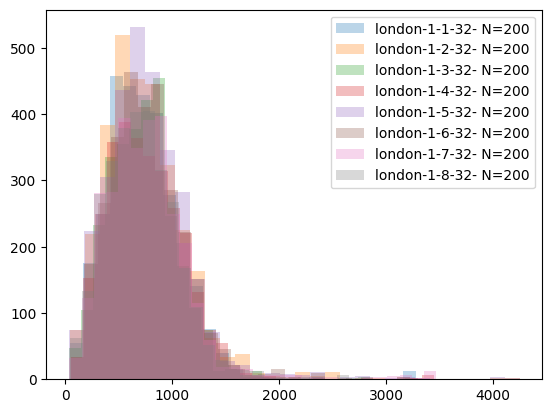

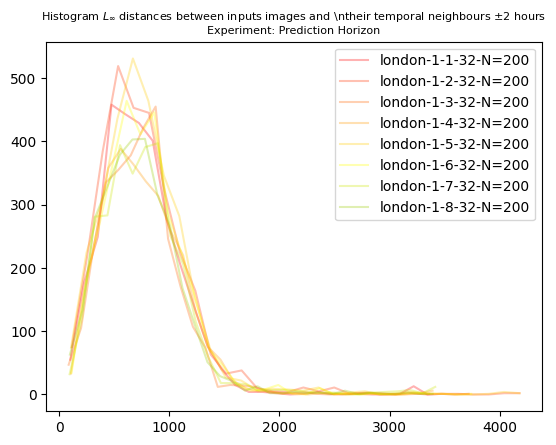

 84%|████████▍ | 338/400 [00:01<00:00, 301.90it/s]

Boundary case; skipping this query point


 61%|██████    | 244/400 [00:00<00:00, 298.46it/s]

Boundary case; skipping this query point


100%|██████████| 400/400 [00:01<00:00, 296.74it/s]


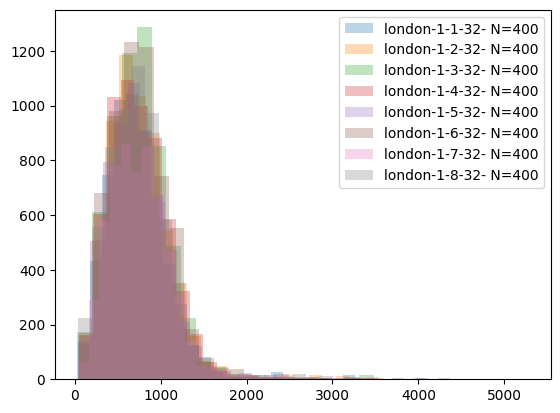

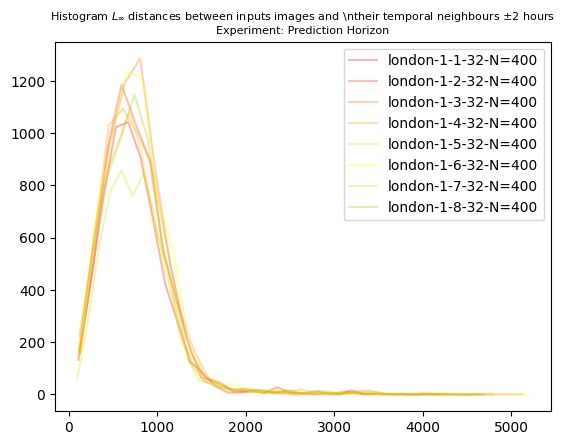

100%|██████████| 800/800 [00:02<00:00, 304.47it/s]


Boundary case; skipping this query point


 58%|█████▊    | 465/800 [00:01<00:01, 305.87it/s]

Boundary case; skipping this query point


 43%|████▎     | 341/800 [00:01<00:01, 303.23it/s]

Boundary case; skipping this query point


 31%|███       | 248/800 [00:00<00:01, 302.98it/s]

Boundary case; skipping this query point


100%|██████████| 800/800 [00:02<00:00, 300.20it/s]


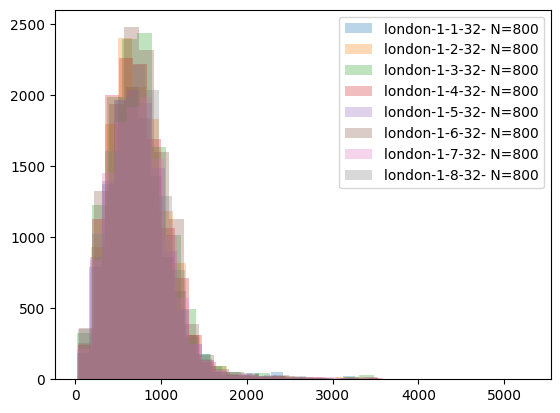

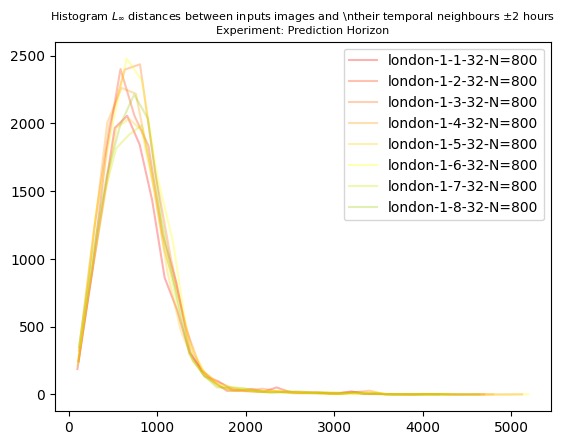

In [82]:
for city in config.city_list:

    # pred_horiz
    for N in [200, 400, 800]:
        hist_list = []
        colors = ["#FF0000", "#FF3300", "#FF6600", "#FF9900", "#FFCC00", "#FFFF00", "#CCE600", "#99CC00", "#66B200", "#339900"]
        for scale in config.scales_def:
            for i_o_length in config.i_o_lengths_def:
                for index, pred_horiz in enumerate(config.pred_horiz):
                    prefix = ProcessRaw.file_prefix(city, i_o_length, pred_horiz, scale)
                    # sprint (prefix)
                    train_file_list_filtered = [x for x in train_file_list if (prefix in x and "_x.npy" in x)]
                    # sprint (len(train_file_list_filtered))
                    distances = compute_distances_of_x(train_file_list_filtered, prefix, "../../../train_data_all_cities/", N=N)

                    hist = plt.hist(distances, bins=30, alpha=0.3, label=prefix + " N=" + str(N))
                    bincentres = (hist[1][:-1] + hist[1][1:]) / 2

                    hist_list.append((hist[0], bincentres, prefix + "N=" +str(N), colors[index])) # hist[0] since plt.hist returns the bin counts, then the bin boundaries
                    # plt.plot()
        plt.legend()
        plt.show()


        for hist in hist_list:
            # hist[1]: x labels (the bin centres)
            # hist[0]: The actual bin counts
            # hist[3]: colors
            # hist[2]: label
            plt.plot(hist[1], hist[0], label=hist[2], color=hist[3], alpha=0.3,)
            plt.title(r"Histogram $L_{\infty}$ distances between inputs images and \ntheir temporal neighbours $\pm$2 hours " + "\nExperiment: Prediction Horizon", fontsize=8)
        plt.legend()
        plt.show()
    
    


100%|██████████| 100/100 [00:00<00:00, 1600.45it/s]


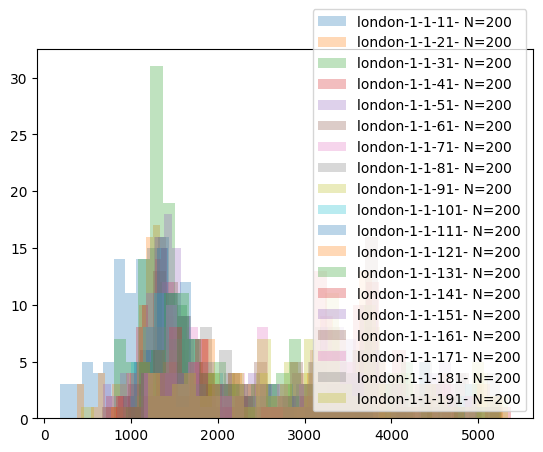

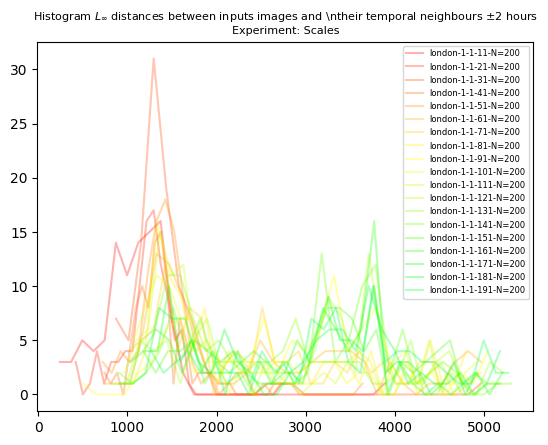

100%|██████████| 200/200 [00:00<00:00, 1583.22it/s]


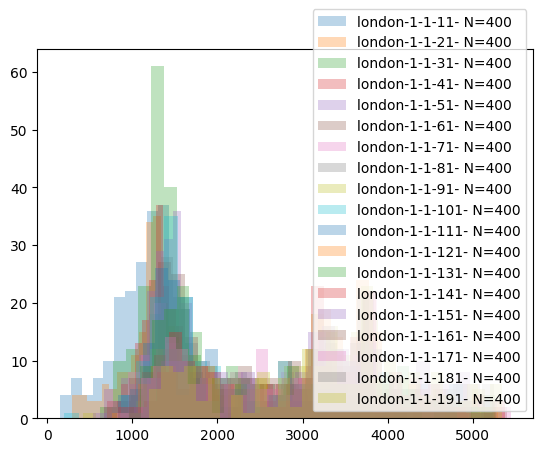

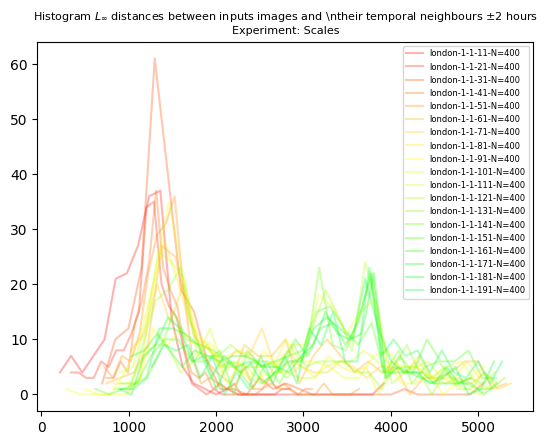

100%|██████████| 400/400 [00:00<00:00, 1588.41it/s]


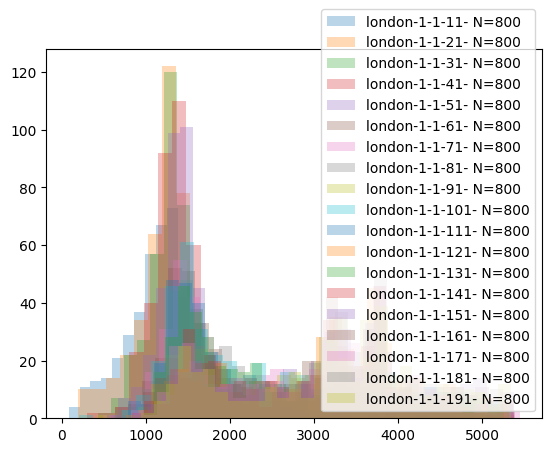

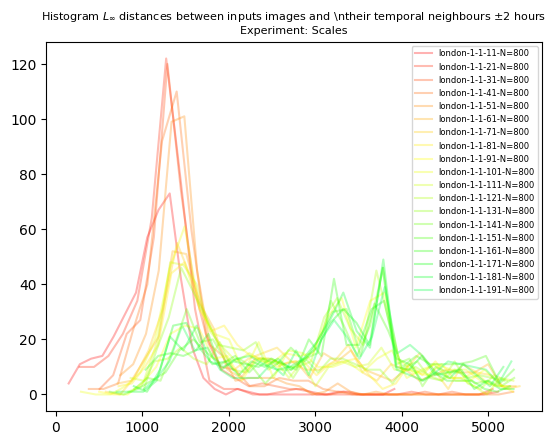

In [91]:
for city in config.city_list:

    # scale
    for N in [200, 400, 800]:
        hist_list = []
        colors = ["#FF0000", "#FF2200", "#FF4400", "#FF6600", "#FF8800", "#FFAA00", "#FFCC00", "#FFEE00", "#FFFF00", \
                  "#EEFF00", "#CCFF00", "#AAFF00", "#88FF00", "#66FF00", "#44FF00", "#22FF00", "#00FF00", "#00FF22", "#00FF44", "#00FF66", "#00FF88", \
                  "#00FFAA", "#00FFCC", "#00FFEE", "#00FFFF", "#00EEFF", "#00CCFF", "#00AAFF", "#0088FF", "#0066FF", "#0044FF", "#0022FF", "#0000FF"]
        for index, scale in enumerate(config.scales[1:]):
            for i_o_length in config.i_o_lengths_def:
                for pred_horiz in config.pred_horiz_def:
                    prefix = ProcessRaw.file_prefix(city, i_o_length, pred_horiz, scale)
                    # sprint (prefix)
                    train_file_list_filtered = [x for x in train_file_list if (prefix in x and "_x.npy" in x)]
                    # sprint (len(train_file_list_filtered))
                    distances = compute_distances_of_x_random_neighbours(train_file_list_filtered, prefix, "../../../train_data_all_cities/", N=N)

                    hist = plt.hist(distances, bins=30, alpha=0.3, label=prefix + " N=" + str(N))
                    bincentres = (hist[1][:-1] + hist[1][1:]) / 2

                    hist_list.append((hist[0], bincentres, prefix + "N=" +str(N), colors[index])) # hist[0] since plt.hist returns the bin counts, then the bin boundaries
                    # plt.plot()
        plt.legend()
        plt.show()


        for hist in hist_list:
            # hist[1]: x labels (the bin centres)
            # hist[0]: The actual bin counts
            # hist[3]: colors
            # hist[2]: label
            plt.plot(hist[1], hist[0], label=hist[2], color=hist[3], alpha=0.3)
            plt.title(r"Histogram $L_{\infty}$ distances between inputs images and \ntheir "\
                      "temporal neighbours $\pm$2 hours " + "\nExperiment: Scales", fontsize=8)
        plt.legend(fontsize=6)
        plt.show()

 49%|████▉     | 98/200 [00:02<00:02, 40.80it/s]

Boundary case; skipping this query point


100%|██████████| 200/200 [00:01<00:00, 171.63it/s]

Boundary case; skipping this query point


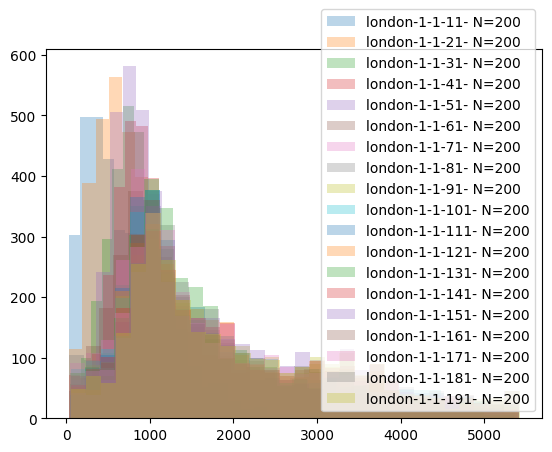

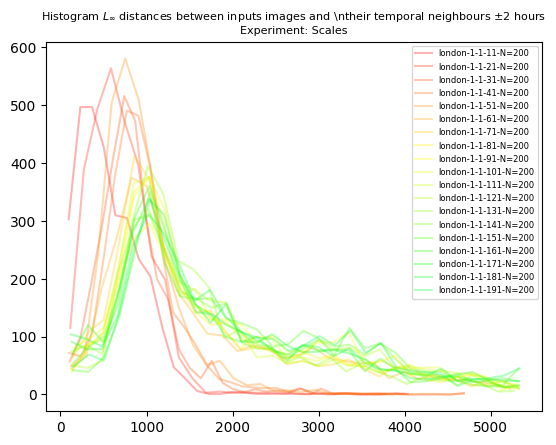

100%|██████████| 400/400 [00:02<00:00, 172.56it/s]


Boundary case; skipping this query point


 58%|█████▊    | 233/400 [00:00<00:00, 199.25it/s]

Boundary case; skipping this query point


 87%|████████▋ | 348/400 [00:02<00:00, 100.47it/s]

Boundary case; skipping this query point


 30%|███       | 121/400 [00:00<00:01, 234.23it/s]

Boundary case; skipping this query point


 55%|█████▍    | 219/400 [00:02<00:03, 54.81it/s] 

Boundary case; skipping this query point


 72%|███████▏  | 289/400 [00:02<00:01, 57.89it/s] 

Boundary case; skipping this query point


 49%|████▉     | 197/400 [00:01<00:01, 172.84it/s]

Boundary case; skipping this query point


100%|██████████| 400/400 [00:02<00:00, 169.85it/s]


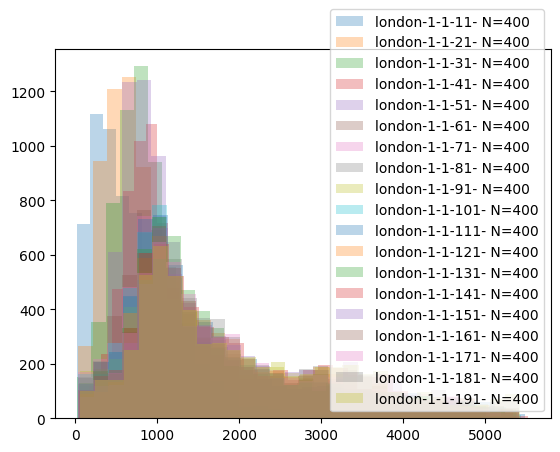

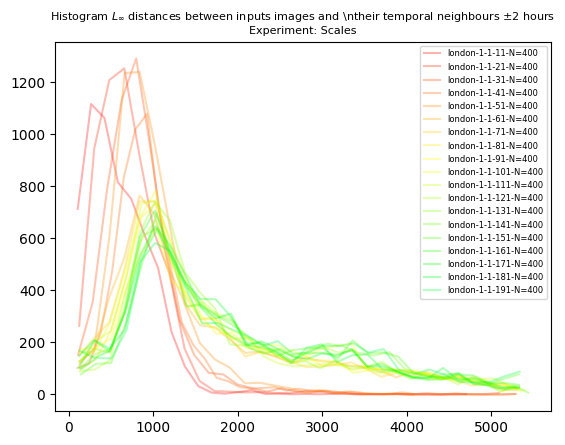

 50%|█████     | 403/800 [00:01<00:01, 297.52it/s]

Boundary case; skipping this query point
Boundary case; skipping this query point


 83%|████████▎ | 666/800 [00:03<00:00, 138.12it/s]

Boundary case; skipping this query point


 33%|███▎      | 266/800 [00:00<00:01, 291.70it/s]

Boundary case; skipping this query point


 47%|████▋     | 378/800 [00:01<00:01, 263.56it/s]

Boundary case; skipping this query point


 75%|███████▍  | 597/800 [00:03<00:02, 99.28it/s] 

Boundary case; skipping this query point


 76%|███████▋  | 612/800 [00:04<00:02, 89.94it/s] 

Boundary case; skipping this query point


 15%|█▌        | 121/800 [00:00<00:02, 232.47it/s]

Boundary case; skipping this query point


 74%|███████▍  | 595/800 [00:05<00:03, 54.15it/s] 

Boundary case; skipping this query point


 91%|█████████▏| 730/800 [00:07<00:00, 78.77it/s] 

Boundary case; skipping this query point


 30%|███       | 243/800 [00:01<00:02, 199.90it/s]

Boundary case; skipping this query point


 78%|███████▊  | 620/800 [00:06<00:03, 59.10it/s] 

Boundary case; skipping this query point


 38%|███▊      | 300/800 [00:01<00:02, 195.38it/s]

Boundary case; skipping this query point


 92%|█████████▏| 736/800 [00:08<00:01, 46.35it/s] 

Boundary case; skipping this query point


 25%|██▍       | 198/800 [00:01<00:03, 172.83it/s]

Boundary case; skipping this query point


100%|██████████| 800/800 [00:04<00:00, 173.60it/s]


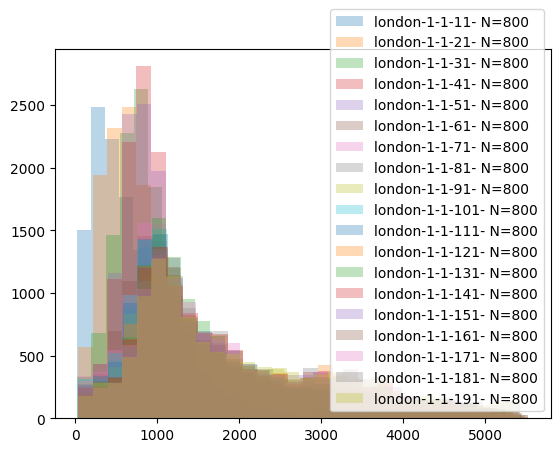

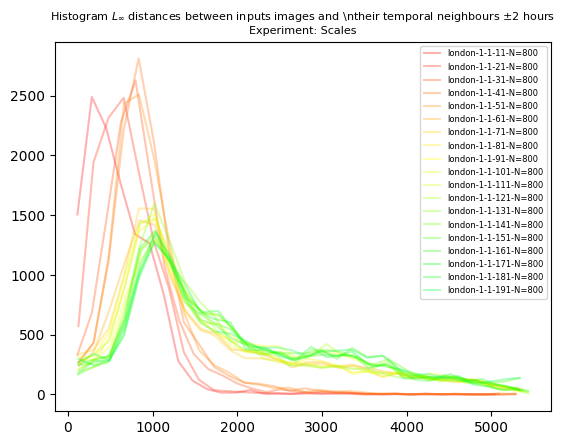

In [83]:
for city in config.city_list:

    # scale
    for N in [200, 400, 800]:
        hist_list = []
        colors = ["#FF0000", "#FF2200", "#FF4400", "#FF6600", "#FF8800", "#FFAA00", "#FFCC00", "#FFEE00", "#FFFF00", \
                  "#EEFF00", "#CCFF00", "#AAFF00", "#88FF00", "#66FF00", "#44FF00", "#22FF00", "#00FF00", "#00FF22", "#00FF44", "#00FF66", "#00FF88", \
                  "#00FFAA", "#00FFCC", "#00FFEE", "#00FFFF", "#00EEFF", "#00CCFF", "#00AAFF", "#0088FF", "#0066FF", "#0044FF", "#0022FF", "#0000FF"]
        for index, scale in enumerate(config.scales[1:]):
            for i_o_length in config.i_o_lengths_def:
                for pred_horiz in config.pred_horiz_def:
                    prefix = ProcessRaw.file_prefix(city, i_o_length, pred_horiz, scale)
                    # sprint (prefix)
                    train_file_list_filtered = [x for x in train_file_list if (prefix in x and "_x.npy" in x)]
                    # sprint (len(train_file_list_filtered))
                    distances = compute_distances_of_x(train_file_list_filtered, prefix, "../../../train_data_all_cities/", N=N)

                    hist = plt.hist(distances, bins=30, alpha=0.3, label=prefix + " N=" + str(N))
                    bincentres = (hist[1][:-1] + hist[1][1:]) / 2

                    hist_list.append((hist[0], bincentres, prefix + "N=" +str(N), colors[index])) # hist[0] since plt.hist returns the bin counts, then the bin boundaries
                    # plt.plot()
        plt.legend()
        plt.show()


        for hist in hist_list:
            # hist[1]: x labels (the bin centres)
            # hist[0]: The actual bin counts
            # hist[3]: colors
            # hist[2]: label
            plt.plot(hist[1], hist[0], label=hist[2], color=hist[3], alpha=0.3)
            plt.title(r"Histogram $L_{\infty}$ distances between inputs images and \ntheir "\
                      "temporal neighbours $\pm$2 hours " + "\nExperiment: Scales", fontsize=8)
        plt.legend(fontsize=6)
        plt.show()

100%|██████████| 100/100 [00:00<00:00, 2189.81it/s]


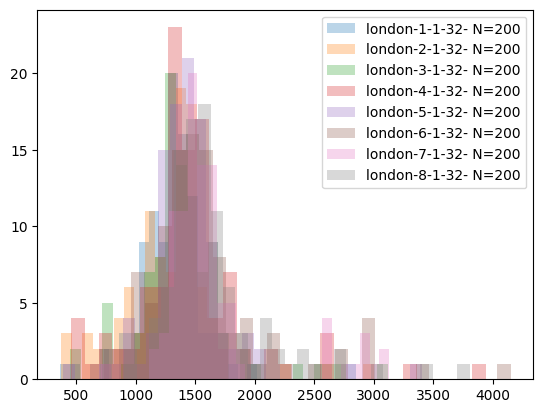

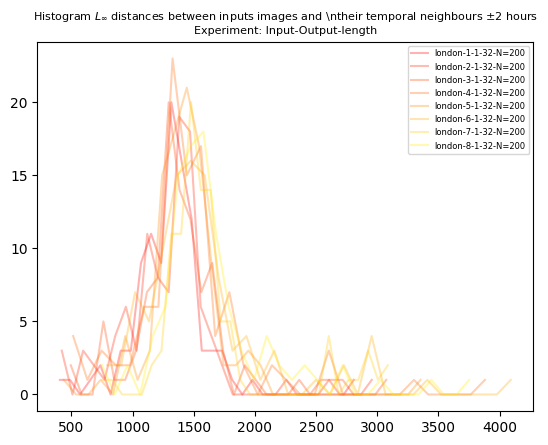

100%|██████████| 200/200 [00:00<00:00, 2221.81it/s]


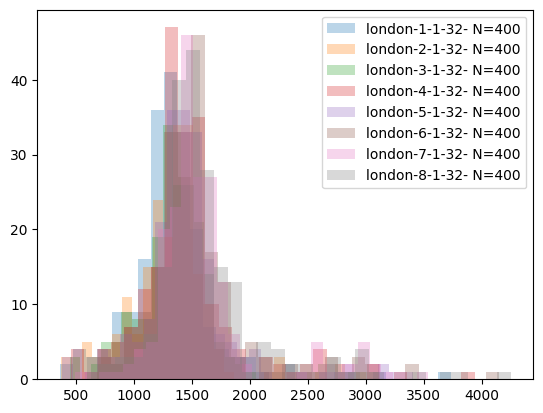

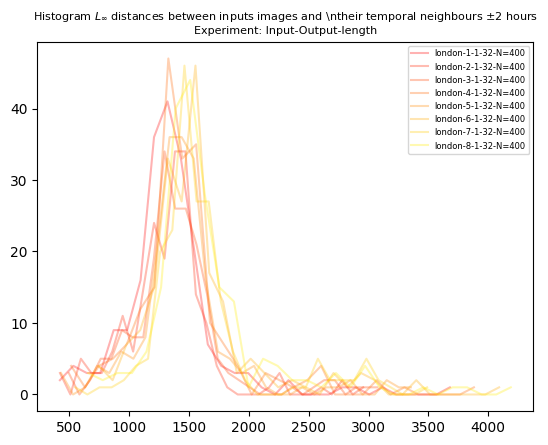

100%|██████████| 400/400 [00:00<00:00, 2249.19it/s]


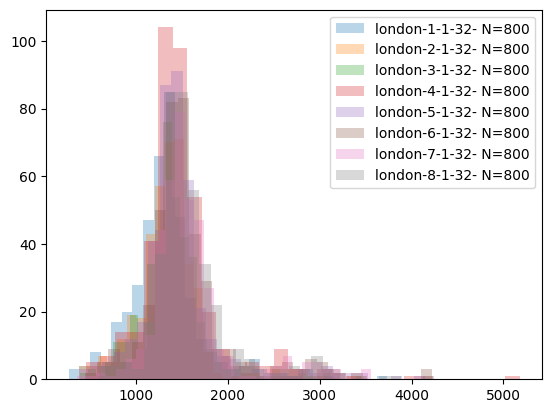

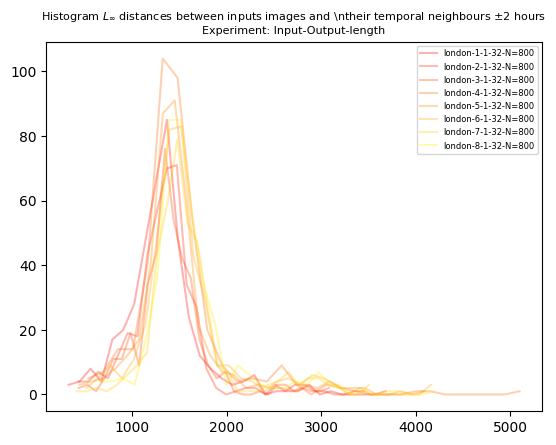

In [92]:
for city in config.city_list:

    # input output
    for N in [200, 400, 800]:
        hist_list = []
        colors = ["#FF0000", "#FF2200", "#FF4400", "#FF6600", "#FF8800", "#FFAA00", "#FFCC00", "#FFEE00", "#FFFF00", \
                  "#EEFF00", "#CCFF00", "#AAFF00", "#88FF00", "#66FF00", "#44FF00", "#22FF00", "#00FF00", "#00FF22", "#00FF44", "#00FF66", "#00FF88", \
                  "#00FFAA", "#00FFCC", "#00FFEE", "#00FFFF", "#00EEFF", "#00CCFF", "#00AAFF", "#0088FF", "#0066FF", "#0044FF", "#0022FF", "#0000FF"]
        for scale in config.scales_def:
            for index, i_o_length in enumerate(config.i_o_lengths):
                for pred_horiz in config.pred_horiz_def:
                    prefix = ProcessRaw.file_prefix(city, i_o_length, pred_horiz, scale)
                    # sprint (prefix)
                    train_file_list_filtered = [x for x in train_file_list if (prefix in x and "_x.npy" in x)]
                    # sprint (len(train_file_list_filtered))
                    distances = compute_distances_of_x_random_neighbours(train_file_list_filtered, prefix, "../../../train_data_all_cities/", N=N)

                    hist = plt.hist(distances, bins=30, alpha=0.3, label=prefix + " N=" + str(N))
                    bincentres = (hist[1][:-1] + hist[1][1:]) / 2

                    hist_list.append((hist[0], bincentres, prefix + "N=" +str(N), colors[index])) # hist[0] since plt.hist returns the bin counts, then the bin boundaries
                    # plt.plot()
        plt.legend()
        plt.show()


        for hist in hist_list:
            # hist[1]: x labels (the bin centres)
            # hist[0]: The actual bin counts
            # hist[3]: colors
            # hist[2]: label
            plt.plot(hist[1], hist[0], label=hist[2], color=hist[3], alpha=0.3)
            plt.title(r"Histogram $L_{\infty}$ distances between inputs images and \ntheir "\
                      "temporal neighbours $\pm$2 hours " + "\nExperiment: Input-Output-length", fontsize=8)
        plt.legend(fontsize=6)
        plt.show()

100%|██████████| 200/200 [00:00<00:00, 258.08it/s]


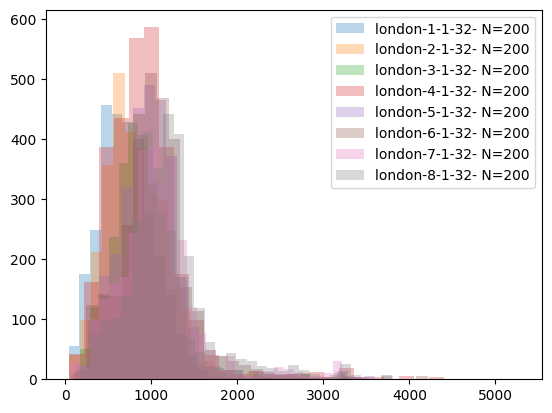

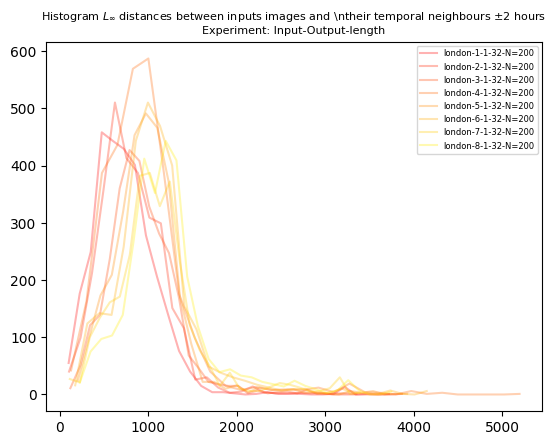

 78%|███████▊  | 313/400 [00:02<00:01, 63.59it/s] 

Boundary case; skipping this query point


 94%|█████████▎| 374/400 [00:03<00:00, 57.26it/s] 

Boundary case; skipping this query point


100%|██████████| 400/400 [00:01<00:00, 255.92it/s]


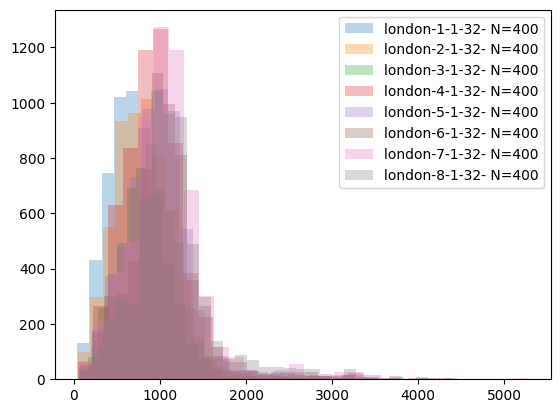

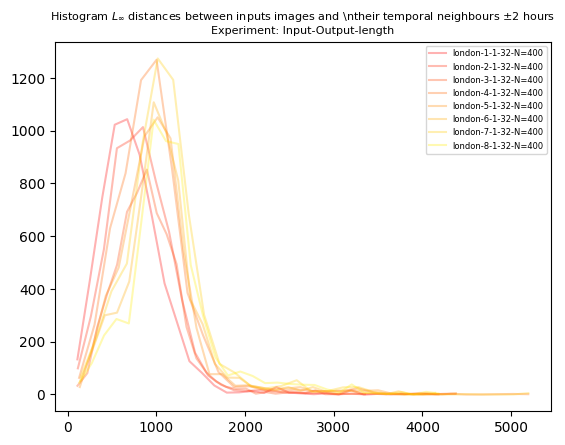

 68%|██████▊   | 540/800 [00:03<00:02, 105.72it/s]

Boundary case; skipping this query point


 72%|███████▏  | 577/800 [00:03<00:02, 100.26it/s]

Boundary case; skipping this query point


 44%|████▎     | 348/800 [00:01<00:01, 281.54it/s]

Boundary case; skipping this query point


 79%|███████▉  | 635/800 [00:05<00:01, 85.69it/s] 

Boundary case; skipping this query point


 51%|█████     | 405/800 [00:01<00:01, 265.50it/s]

Boundary case; skipping this query point


100%|██████████| 800/800 [00:03<00:00, 253.78it/s]


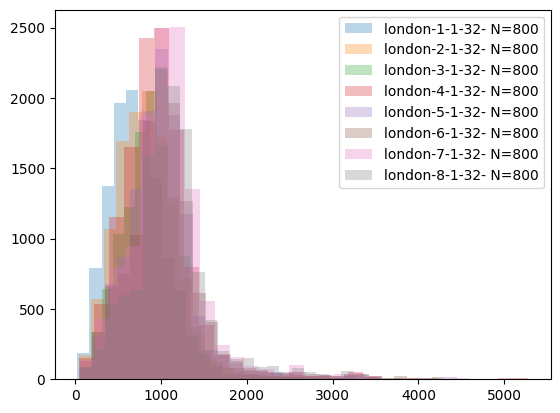

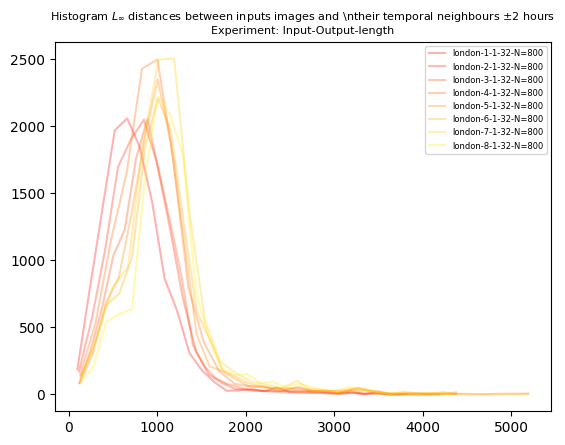

In [84]:
for city in config.city_list:

    # input output
    for N in [200, 400, 800]:
        hist_list = []
        colors = ["#FF0000", "#FF2200", "#FF4400", "#FF6600", "#FF8800", "#FFAA00", "#FFCC00", "#FFEE00", "#FFFF00", \
                  "#EEFF00", "#CCFF00", "#AAFF00", "#88FF00", "#66FF00", "#44FF00", "#22FF00", "#00FF00", "#00FF22", "#00FF44", "#00FF66", "#00FF88", \
                  "#00FFAA", "#00FFCC", "#00FFEE", "#00FFFF", "#00EEFF", "#00CCFF", "#00AAFF", "#0088FF", "#0066FF", "#0044FF", "#0022FF", "#0000FF"]
        for scale in config.scales_def:
            for index, i_o_length in enumerate(config.i_o_lengths):
                for pred_horiz in config.pred_horiz_def:
                    prefix = ProcessRaw.file_prefix(city, i_o_length, pred_horiz, scale)
                    # sprint (prefix)
                    train_file_list_filtered = [x for x in train_file_list if (prefix in x and "_x.npy" in x)]
                    # sprint (len(train_file_list_filtered))
                    distances = compute_distances_of_x(train_file_list_filtered, prefix, "../../../train_data_all_cities/", N=N)

                    hist = plt.hist(distances, bins=30, alpha=0.3, label=prefix + " N=" + str(N))
                    bincentres = (hist[1][:-1] + hist[1][1:]) / 2

                    hist_list.append((hist[0], bincentres, prefix + "N=" +str(N), colors[index])) # hist[0] since plt.hist returns the bin counts, then the bin boundaries
                    # plt.plot()
        plt.legend()
        plt.show()


        for hist in hist_list:
            # hist[1]: x labels (the bin centres)
            # hist[0]: The actual bin counts
            # hist[3]: colors
            # hist[2]: label
            plt.plot(hist[1], hist[0], label=hist[2], color=hist[3], alpha=0.3)
            plt.title(r"Histogram $L_{\infty}$ distances between inputs images and \ntheir "\
                      "temporal neighbours $\pm$2 hours " + "\nExperiment: Input-Output-length", fontsize=8)
        plt.legend(fontsize=6)
        plt.show()